In [ ]:
!pip install SentencePiece 

In [1]:
import transformers 
from transformers import XLNetTokenizer, XLNetModel, AdamW, get_linear_schedule_with_warmup
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import seaborn as sns


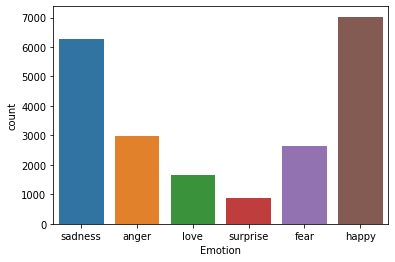

In [2]:
df = pd.read_csv("Emotion_final.csv")
sns.countplot(df.Emotion)

In [3]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df["Emotion"] = label_encoder.fit_transform(df["Emotion"])
print(df)

                                                    Text  Emotion
0                                i didnt feel humiliated        4
1      i can go from feeling so hopeless to so damned...        4
2       im grabbing a minute to post i feel greedy wrong        0
3      i am ever feeling nostalgic about the fireplac...        3
4                                   i am feeling grouchy        0
...                                                  ...      ...
21454               Melissa stared at her friend in dism        1
21455  Successive state elections have seen the gover...        1
21456               Vincent was irritated but not dismay        1
21457  Kendall-Hume turned back to face the dismayed ...        1
21458                    I am dismayed , but not surpris        1

[21459 rows x 2 columns]


In [4]:
print("SHAPE::",df.shape)

SHAPE:: (21459, 2)


In [5]:
class_name = ['sadness','anger','love','surprise','fear','happy']

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
device

device(type='cpu')

In [8]:
PRE_TRAINED_MODEL_NAME = 'xlnet-base-cased'

In [9]:
tokenizer = XLNetTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [10]:
bert_model = XLNetModel.from_pretrained(PRE_TRAINED_MODEL_NAME)


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetModel: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


100%|██████████████████████████████████████████████████████████████████████████| 21459/21459 [00:08<00:00, 2605.25it/s]


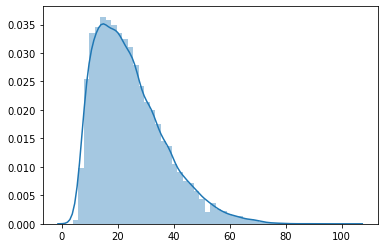

In [11]:
from tqdm import tqdm
token_lens = []
for txt in tqdm(df.Text):
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))
sns.distplot(token_lens)

In [12]:
from torch.utils.data import Dataset, DataLoader
class TextDataset(Dataset):
    def __init__(self,texts,targets,tokenizer,max_len):
        self.texts = texts
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self,item):
        text = str(self.texts[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
            )
        
        return {
            'text_text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
            }

In [13]:
size=len(df)
df_test = df[0:int(size/8)]
df_val = df[int(size/8):int(size/4)]
df_train = df[int(size/4):size]

In [14]:
df_train.shape, df_val.shape, df_test.shape


((16095, 2), (2682, 2), (2682, 2))

In [15]:
print(df)

                                                    Text  Emotion
0                                i didnt feel humiliated        4
1      i can go from feeling so hopeless to so damned...        4
2       im grabbing a minute to post i feel greedy wrong        0
3      i am ever feeling nostalgic about the fireplac...        3
4                                   i am feeling grouchy        0
...                                                  ...      ...
21454               Melissa stared at her friend in dism        1
21455  Successive state elections have seen the gover...        1
21456               Vincent was irritated but not dismay        1
21457  Kendall-Hume turned back to face the dismayed ...        1
21458                    I am dismayed , but not surpris        1

[21459 rows x 2 columns]


In [16]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(df_train.Emotion.values),
                                                 df_train.Emotion.values)

In [17]:
class_weights

array([1.17550394, 1.32273176, 0.51586538, 2.21145919, 0.56917038,
       4.07056146])

In [18]:
def create_data_loader(df,tokenizer,max_len,batch_size):
    ds = TextDataset(
        texts = df.Text.to_numpy(), 
        targets = df.Emotion.to_numpy(),
        tokenizer = tokenizer,
        max_len=max_len)

    return DataLoader(ds,
                      batch_size=batch_size,
                      num_workers=0)

In [19]:
MAX_LEN=10
BATCH_SIZE = 5
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [32]:
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = XLNetModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.4)
        #self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
        self.out1 = nn.Linear(self.bert.config.hidden_size, 128)
        self.drop1 = nn.Dropout(p=0.4)
        self.relu = nn.ReLU()
        self.out = nn.Linear(128, n_classes)

    def forward(self, input_ids, attention_mask):
        pooled_output = self.bert(
          input_ids=input_ids,
          attention_mask=attention_mask,
          return_dict=False
        )
        #output = self.relu(pooled_output)
        hidden_state = pooled_output[0]
        output = hidden_state[:,0]
        output = self.drop(output)
        output = self.out1(output)
        output = self.relu(output)
        output = self.drop1(output)
        return self.out(output)

In [33]:
model = SentimentClassifier(len(class_name))
model = model.to(device)

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetModel: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [34]:
EPOCHS = 5
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
#class_weights = torch.FloatTensor(class_weights).to(device)
#weight=class_weights
loss_fn = nn.CrossEntropyLoss().to(device)

In [35]:
def train_epoch(model,data_loader,loss_fn,optimizer,device,scheduler,n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0
    print(data_loader)
    for data in data_loader:
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        targets = data['targets'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            )
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs,targets)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

In [36]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
      model = model.eval()
      losses = []
      correct_predictions = 0
      with torch.no_grad():
        for d in data_loader:
          input_ids = d["input_ids"].to(device)
          attention_mask = d["attention_mask"].to(device)
          targets = d["targets"].to(device)
          outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
          )
          _, preds = torch.max(outputs, dim=1)
          loss = loss_fn(outputs, targets)
          correct_predictions += torch.sum(preds == targets)
          losses.append(loss.item())
      return correct_predictions.double() / n_examples, np.mean(losses)

In [37]:
from collections import defaultdict
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)
    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )
    print(f'Train loss {train_loss} accuracy {train_acc}')
    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
    )
    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

Epoch 1/5
----------
Train loss 1.6150561302934887 accuracy 0.34122398260329295
Val   loss 10.94851745395909 accuracy 0.11819537658463833

Epoch 2/5
----------
Train loss 1.5814199660176143 accuracy 0.3501087294190742
Val   loss 10.656779169370342 accuracy 0.11819537658463833

Epoch 3/5
----------
Train loss 1.6145613469346491 accuracy 0.35712954333643987
Val   loss 7.817631455551091 accuracy 0.11819537658463833

Epoch 4/5
----------
Train loss 1.560481389049495 accuracy 0.35955265610438025
Val   loss 8.147840625080983 accuracy 0.11819537658463833

Epoch 5/5
----------
Train loss 1.634865110447852 accuracy 0.315439577508543
Val   loss 1.5771882072285346 accuracy 0.3340790454884415



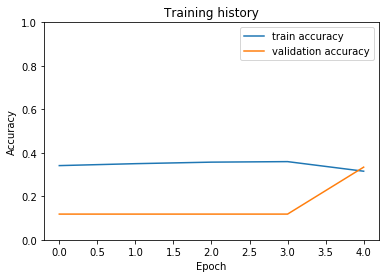

In [38]:
import matplotlib.pyplot as plt
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [39]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)
test_acc.item()

C:\Users\Fatemeh\anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


0.3478747203579418

In [40]:
def get_predictions(model, data_loader):
    model = model.eval()
    text_texts = []
    predictions = []
    prediction_probs = []
    real_values = []
    with torch.no_grad():
    for d in data_loader:
        texts = d["text_text"]
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)
        outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
        _, preds = torch.max(outputs, dim=1)
        text_texts.extend(texts)
        predictions.extend(preds)
        prediction_probs.extend(outputs)
        real_values.extend(targets)
    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return text_texts, predictions, prediction_probs, real_values

In [41]:
y_text_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [42]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test, y_pred, target_names=class_name))

              precision    recall  f1-score   support

     sadness       0.00      0.00      0.00       370
       anger       0.00      0.00      0.00       307
        love       0.35      1.00      0.52       933
    surprise       0.00      0.00      0.00       216
        fear       0.00      0.00      0.00       745
       happy       0.00      0.00      0.00       111

    accuracy                           0.35      2682
   macro avg       0.06      0.17      0.09      2682
weighted avg       0.12      0.35      0.18      2682



C:\Users\Fatemeh\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


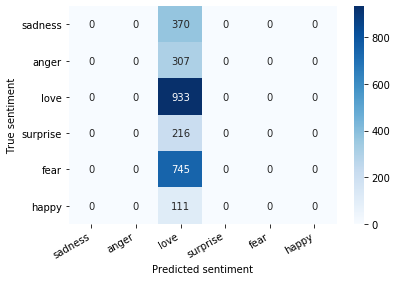

In [43]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_name, columns=class_name)
show_confusion_matrix(df_cm)

<div dir="rtl">
اینجا هم به نظر حماسه آفریدم! اما این دفعه حتی نمیدونم چرا! 
</div>